In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

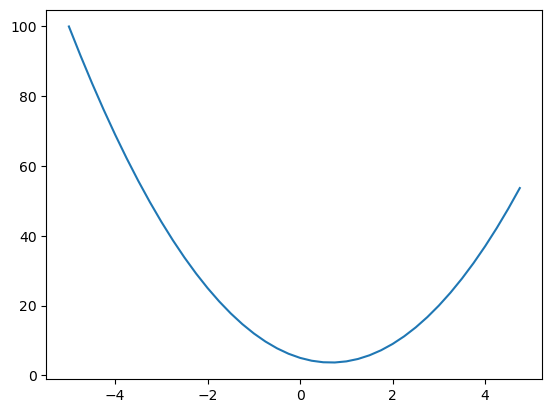

In [3]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
h = 0.0000001
x = 2/3
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [5]:
h = 0.0001

a = 2.
b = -3.
c = 10.

d1 = a*b + c
c+=h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [85]:
class Value:
    def __init__(self,data,_children = (),_op = '',label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.label = label
        self.grad = 0
    def __repr__(self):
       return f"Value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self*other
    def __radd__(self, other):
        return self+other
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out
    def __sub__(self, other):
        return self + (-other)
    def __neg__(self):
        return self*-1
    def __truediv__(self, other):
        return self * other**-1
    def __pow__(self, other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1. - t**2)*out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.
        for node in reversed(topo):
            node._backward()


a = Value(2.,label='a')
b =  Value(-3.,label='b')
c = Value(10.,label='c')
e = a*b;e.label='e'
d = e+c;d.label='d'
f = Value(-2.,label='f')
L  = d*f;L.label='L'
L

Value(data=-8.0)

In [108]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(uid,label="{%s | data %.4f | grad %.4f}"%(n.label,n.data,n.grad),shape = "record")
        if n._op:
            dot.node(name = uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)

    return dot

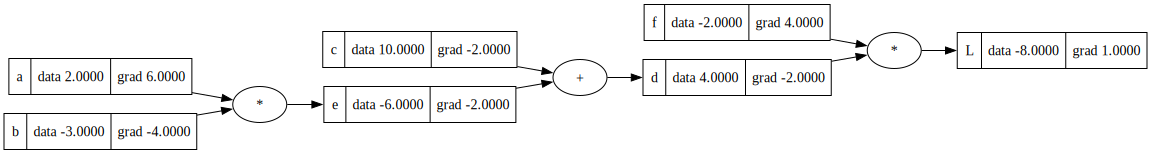

In [24]:
draw_dot(L)

In [25]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [26]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-3.9999999999995595


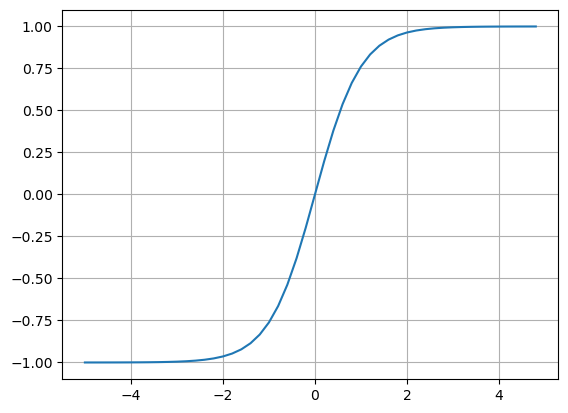

In [27]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [83]:
x1 = Value(2.,label='x1')
x2 = Value(0.,label='x2')

w1 =Value(-3.,label='w1')
w2 =Value(1.,label='w2')
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1;x1w1.label = 'x1*w1'
x2w2 = x2*w2;x2w2.label = 'x2*w2'
x1w1x2w2  =x1w1+x2w2;x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2+b;n.label = 'n'
o = n.tanh();o.label = 'o'
o.backward()

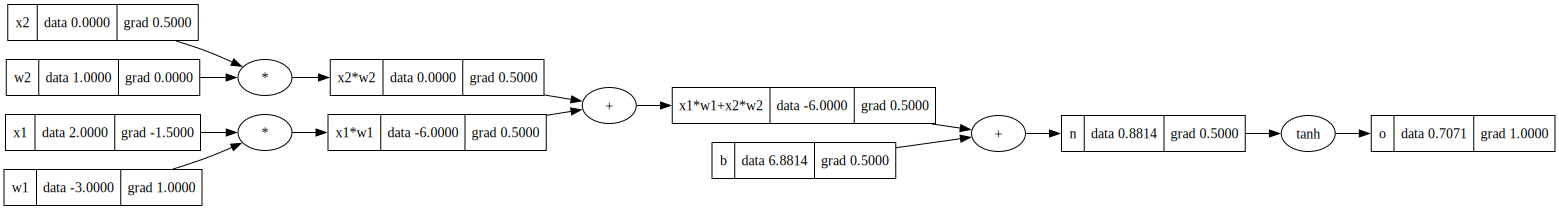

In [84]:
draw_dot(o)

In [87]:
x1 = Value(2.,label='x1')
x2 = Value(0.,label='x2')

w1 =Value(-3.,label='w1')
w2 =Value(1.,label='w2')
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1;x1w1.label = 'x1*w1'
x2w2 = x2*w2;x2w2.label = 'x2*w2'
x1w1x2w2  =x1w1+x2w2;x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2+b;n.label = 'n'
e =  (2*n).exp()
o = (e - 1)/(e + 1);o.label = 'o'
o.backward()

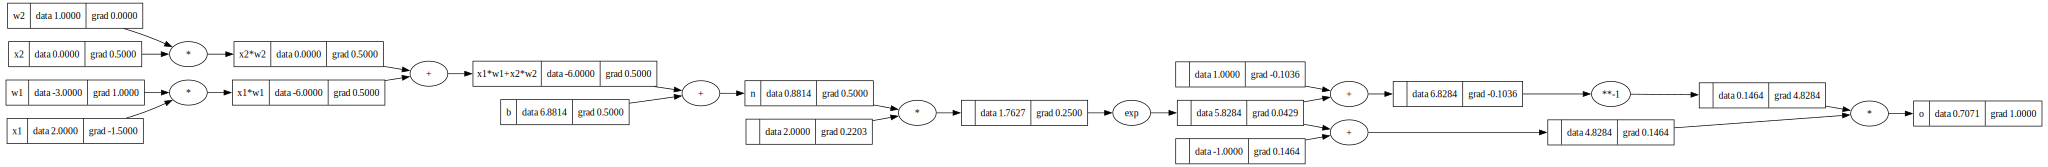

In [88]:
draw_dot(o)

In [90]:
import torch

In [91]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [128]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    def parameters(self): return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        out = [n(x) for n in self.neurons]
        return out
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layer = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layer: x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layer for p in layer.parameters()]


x = [2.,3.,-1]
n = MLP(3,[4,4,1])
n(x)

[Value(data=-0.8853302959516066)]

In [157]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [219]:
for k in range(20):

    ypred = [n(x)[0] for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)


0 0.002113237756568169
1 0.0011767357324376797
2 0.0008221390514187055
3 0.0006313599475129433
4 0.0005116918730389441
5 0.000429566850732894
6 0.00036972816463147126
7 0.0003242113112847444
8 0.0002884444197368603
9 0.00025961356864298037
10 0.00023589141985119963
11 0.00021603961805295927
12 0.00019918924625541003
13 0.0001847127016466763
14 0.00017214543754438837
15 0.00016113630032600398
16 0.0001514149691077102
17 0.00014276999958524178
18 0.00013503365079645376
19 0.0001280711703942293


In [220]:
ypred

[Value(data=0.999999899963156),
 Value(data=-0.9999917457342918),
 Value(data=-0.9886831496324665),
 Value(data=0.9999998991208362)]